# AFRIBERTA CLASSIC 3 LEVEL SENTIMENT ANALYSIS TRAINING

## Python Environment Setup 

In [ ]:
!pip3 install torch torchvision torchaudio
!pip install transformers
!pip install datasets
!pip install simpletransformers
!pip install plotly
# !pip install wandb==0.12.21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import zipfile
import torch
# import wandb

import pandas as pd
import numpy as np
import seaborn as sns

from typing import Dict
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset 
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import  precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report, accuracy_score

from transformers import EvalPrediction
from transformers import Trainer, TrainingArguments, PreTrainedTokenizer
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoTokenizer, XLMRobertaTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorWithPadding, TextClassificationPipeline

In [ ]:
# wandb.login()
# wandb.init(project="all-models-project", entity="african-multitask-finetuning")

## DATA SETUP 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# get training data
train = pd.read_csv('/content/drive/MyDrive/MIT/MIT 807 mini-dissertation/Data/Training data/Swahili/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MIT/MIT 807 mini-dissertation/Data/Training data/Swahili/test.csv')
dev = pd.read_csv('/content/drive/MyDrive/MIT/MIT 807 mini-dissertation/Data/Training data/Swahili/dev.csv')

data = pd.concat([train, test, dev], axis=0)

data

,tweet,label
0,Kwani tanesco wanakataga umeme makusudinadhani...,negative
1,cjawahi kuona content yoyote zaidi ya kuwa ana...,negative
2,Bomu lililokuwa limetegwa ndani ya gari likiwa...,negative
3,Kuna video inasambaa mitandaoni jamaa amemfuma...,negative
4,Viwavijeshi wanapita katika hatua kuu 6 za uku...,negative
...,...,...
448,Usiingie kwenye mahusiano na mtu ambae hutatam...,positive
449,Wapambanaji wa kuleta makombe Msimbazi,neutral
450,Elimu Ni Ufunguo Wa Maisha Sasa huyu mwanafunz...,neutral
451,Viingilio vya tamasha kubwa zaidi nchini Unawe...,neutral


# DATA PROCESSING

## Standard Original Data 

In [63]:
data_labels = data.groupby('label')['label'].count().sort_values(ascending=False).reset_index(name='count')

In [66]:
data_labels

,label,count
0,neutral,1784
1,positive,908
2,negative,319


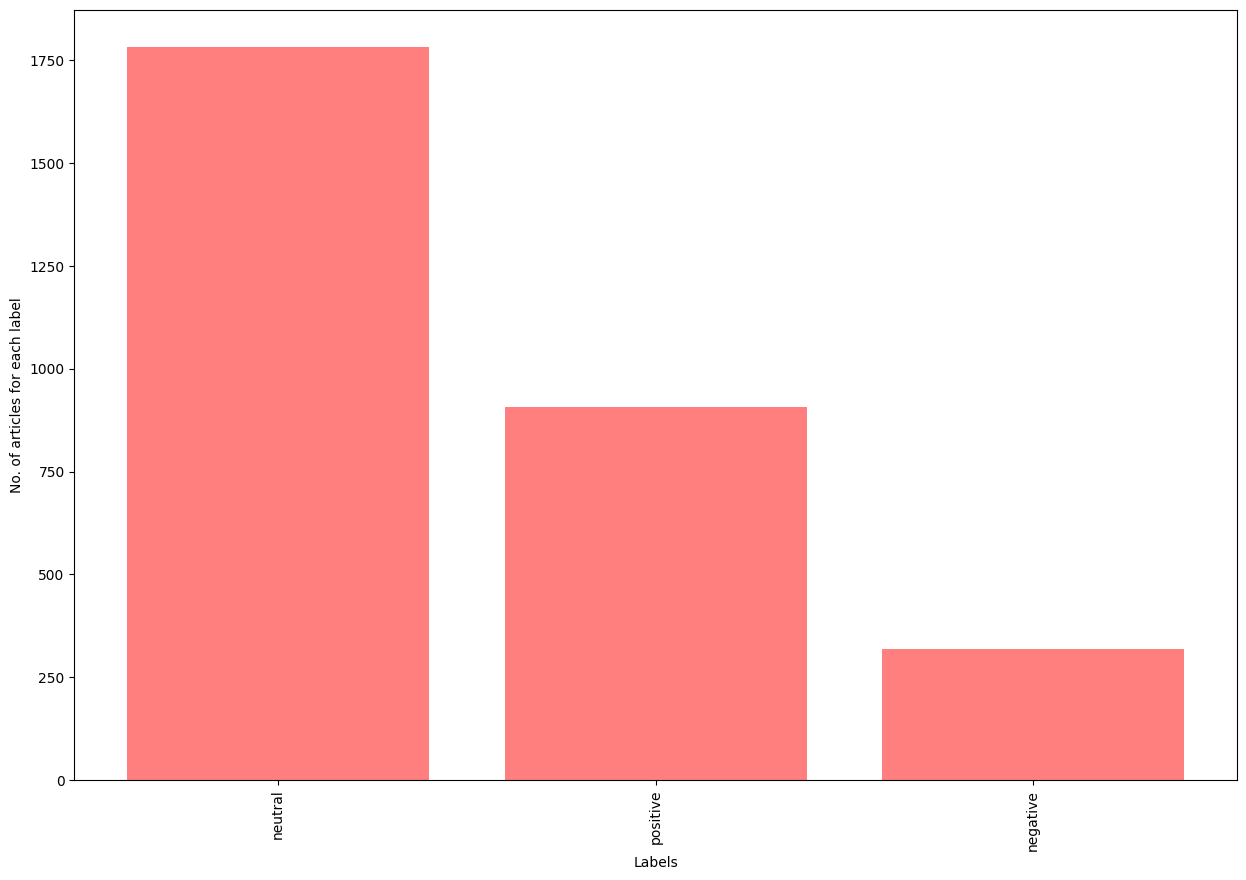

In [ ]:
fig = plt.figure(figsize = (15, 10))

# creating the bar plot
plt.bar(data_labels['label'], data_labels['count'], align = 'center', alpha= 0.5, color ='red')
plt.rcParams['font.size'] = 18
plt.xticks(rotation='vertical') 
plt.xlabel("Labels")
plt.ylabel("No. of articles for each label")
plt.savefig('Class distribution.png')
plt.show()

## Data Preprocessing

In [ ]:
data['labels'] = pd.Categorical(data['label']).codes

In [ ]:
data.head()

,tweet,label,labels
0,Kwani tanesco wanakataga umeme makusudinadhani...,negative,0
1,cjawahi kuona content yoyote zaidi ya kuwa ana...,negative,0
2,Bomu lililokuwa limetegwa ndani ya gari likiwa...,negative,0
3,Kuna video inasambaa mitandaoni jamaa amemfuma...,negative,0
4,Viwavijeshi wanapita katika hatua kuu 6 za uku...,negative,0


In [ ]:
pd.Categorical(data['label']).categories

Index(['negative', 'neutral', 'positive'], dtype='object')

In [ ]:
labels = list(pd.Categorical(data['label']).categories)

In [ ]:
# Reassign each label a number from 0 ... 
labels_index = {label: i for i, label in enumerate(labels)}
labels_index

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
index_labels = {str(i): label for i, label in enumerate(labels)}
index_labels

{'0': 'negative', '1': 'neutral', '2': 'positive'}

## Tokenization

In [ ]:
#Loading the model specific tokenizer 
tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_large")
tokenizer.model_max_length = 512

/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
x_texts = data[['tweet', 'label','labels']]

In [ ]:
# # Normal Data Split 
train_texts, validation_texts = train_test_split(x_texts, test_size=.2)

test_texts, val_texts = train_test_split(validation_texts, test_size=.5)

In [ ]:
temp_train = Dataset.from_pandas(train_texts)

train_dataset = temp_train.map(lambda examples : tokenizer(examples["tweet"], max_length=512, add_special_tokens=True,truncation=True, padding='max_length'), batched=True)
train_dataset.set_format( columns=['input_ids', 'labels', 'attention_mask'])

Map:   0%|          | 0/2408 [00:00<?, ? examples/s]

In [ ]:
temp_test = Dataset.from_pandas(test_texts)

test_dataset = temp_test.map(lambda examples : tokenizer(examples["tweet"], max_length=512, add_special_tokens=True,truncation=True, padding='max_length'), batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'labels', 'attention_mask'])

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

In [ ]:
temp_val = Dataset.from_pandas(val_texts)

eval_dataset = temp_val.map(lambda examples : tokenizer(examples["tweet"], max_length=512, add_special_tokens=True,truncation=True, padding='max_length'), batched=True)
eval_dataset.set_format(type='torch', columns=['input_ids', 'labels', 'attention_mask'])

Map:   0%|          | 0/302 [00:00<?, ? examples/s]

## Afriberta Model 

In [ ]:
modelType = "castorini/afriberta_large"

In [ ]:
num_labels = data["labels"].nunique()

In [ ]:
num_labels

3

In [ ]:
config = AutoConfig.from_pretrained(modelType, num_labels=num_labels, id2label =  index_labels , label2id= labels_index )

In [ ]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(modelType, config=config)

In [ ]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./afriberta_results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    # report_to="wandb",
    do_eval=True,
    do_predict=True,
    weight_decay=0.028385075820435143,
    seed=16978,
    learning_rate=5e-5,
    adafactor=True,
    adam_beta1=0.7640150802510443,
    adam_beta2=0.743931677238676,
    adam_epsilon=3e-8,
    max_grad_norm=0.47726717061800594,
    evaluation_strategy='steps',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    gradient_accumulation_steps=1,
    learning_rate_scheduler_type='linear',
    warmup_steps=0,
    save_total_limit=3,
    dataloader_num_workers=4,
    run_name='run_name',
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.9/dist-packages/transformers/training_args.py:1211: FutureWarning: `--adafactor` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--optim adafactor` instead
  warnings.warn(


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer = Trainer(
            model= None,
            args= training_args,
            train_dataset= train_dataset,
            eval_dataset= test_dataset,
            tokenizer= tokenizer,
            data_collator=data_collator,
            model_init = model_init,
            compute_metrics= compute_metrics
)

Some weights of the model checkpoint at castorini/afriberta_large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.weight', 'classif

In [ ]:
# Now we train the Sequence classifier. be patient this may take a while
trainer.train()

Some weights of the model checkpoint at castorini/afriberta_large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.weight', 'classif

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.950300,0.937637,0.574751,0.574751,0.574751,0.574751
20,0.867300,0.880404,0.548173,0.548173,0.548173,0.548173
30,0.860700,0.885032,0.614618,0.614618,0.614618,0.614618
40,0.882900,0.804159,0.604651,0.604651,0.604651,0.604651
50,0.819100,0.910296,0.504983,0.504983,0.504983,0.504983
60,0.787600,0.853991,0.598007,0.598007,0.598007,0.598007
70,0.860300,0.805650,0.604651,0.604651,0.604651,0.604651
80,0.831500,0.808145,0.601329,0.601329,0.601329,0.601329
90,0.762700,0.765263,0.647841,0.647841,0.647841,0.647841
100,0.749000,0.786921,0.627907,0.627907,0.627907,0.627907


TrainOutput(global_step=302, training_loss=0.6755697111420284, metrics={'train_runtime': 572.0218, 'train_samples_per_second': 8.419, 'train_steps_per_second': 0.528, 'total_flos': 1057427602882560.0, 'train_loss': 0.6755697111420284, 'epoch': 2.0})

In [ ]:
trainer.save_model('/content/drive/MyDrive/MIT/MIT 807 mini-dissertation/Afriberta_Classic_sentiment')

In [ ]:
trainer.evaluate()

{'eval_loss': 0.8244216442108154,
 'eval_accuracy': 0.6411960132890365,
 'eval_f1': 0.6411960132890365,
 'eval_precision': 0.6411960132890365,
 'eval_recall': 0.6411960132890365,
 'eval_runtime': 7.0088,
 'eval_samples_per_second': 42.946,
 'eval_steps_per_second': 2.711,
 'epoch': 2.0}

In [ ]:
afriberta_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/MIT/MIT 807 mini-dissertation/Afriberta_Classic_sentiment", local_files_only=True)

afriberta_trainer = Trainer(model=afriberta_model)
afriberta_trainer.model = afriberta_model.cuda()

In [ ]:
predictions, labels, metrics = afriberta_trainer.predict(eval_dataset)

In [ ]:
y_predictions =list(np.argmax(predictions, axis=1))

In [ ]:
y_true_labels = list(labels)

In [ ]:
# Confusion matrix 
def plot_confusion_matrix(cm, num_of_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(num_of_classes))
    plt.xticks(tick_marks, num_of_classes, rotation=45)
    plt.yticks(tick_marks, num_of_classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true_labels, y_predictions)

In [ ]:
result_dir = '/content/drive/MyDrive/MIT/MIT 807 mini-dissertation//results_afriberta_classic_sentiment'

Confusion matrix, without normalization
[[ 15  19   2]
 [  5 139  40]
 [  1  38  43]]


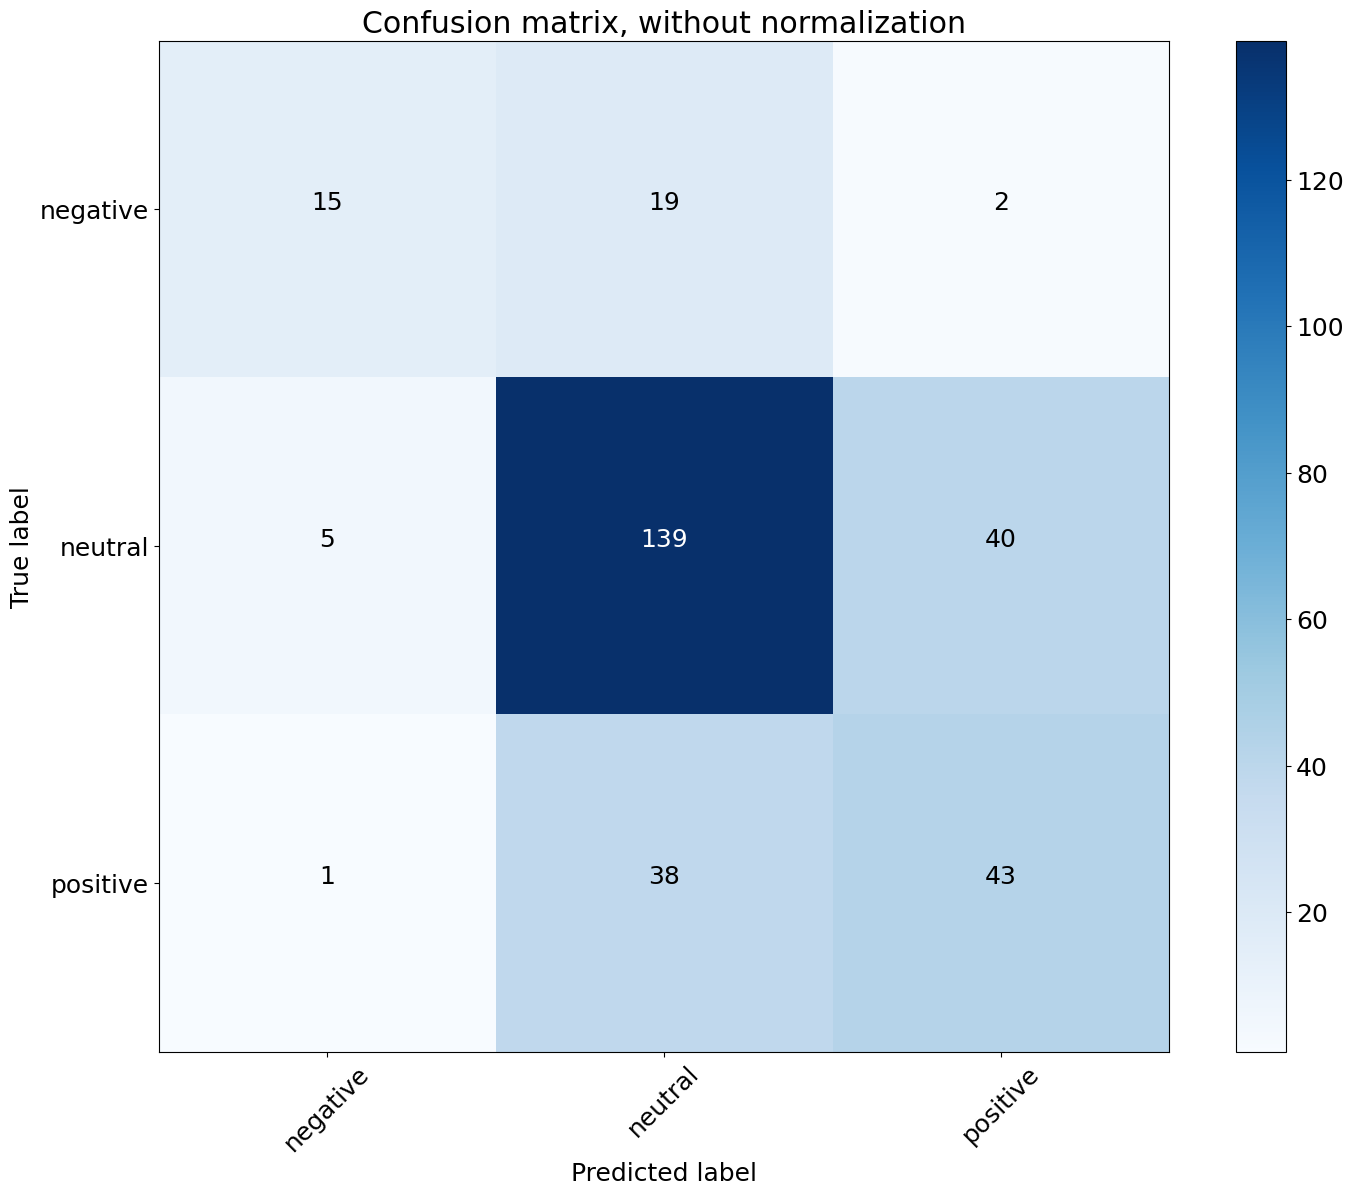

In [ ]:
import itertools

fig, ax = plt.subplots(figsize=(15, 12))
plot_confusion_matrix(cnf_matrix, num_of_classes=['negative', 'neutral', 'positive'], title='Confusion matrix, without normalization')
# plt.savefig(result_dir+'plot_confusion_matrix_2.png')

In [ ]:
label_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true_labels, y_predictions))  #, target_names=label_names))

              precision    recall  f1-score   support

           0       0.71      0.42      0.53        36
           1       0.71      0.76      0.73       184
           2       0.51      0.52      0.51        82

    accuracy                           0.65       302
   macro avg       0.64      0.57      0.59       302
weighted avg       0.65      0.65      0.65       302



In [ ]:
from sklearn.preprocessing import label_binarize

binarized_y_true_labels = label_binarize(y_true_labels, classes=[0, 1, 2])
binarized_y_true_labels.shape

(302, 3)

In [ ]:
print(classification_report(y_true_labels, y_predictions)) 

              precision    recall  f1-score   support

           0       0.71      0.42      0.53        36
           1       0.71      0.76      0.73       184
           2       0.51      0.52      0.51        82

    accuracy                           0.65       302
   macro avg       0.64      0.57      0.59       302
weighted avg       0.65      0.65      0.65       302



<ipython-input-50-34b717fb802a>:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


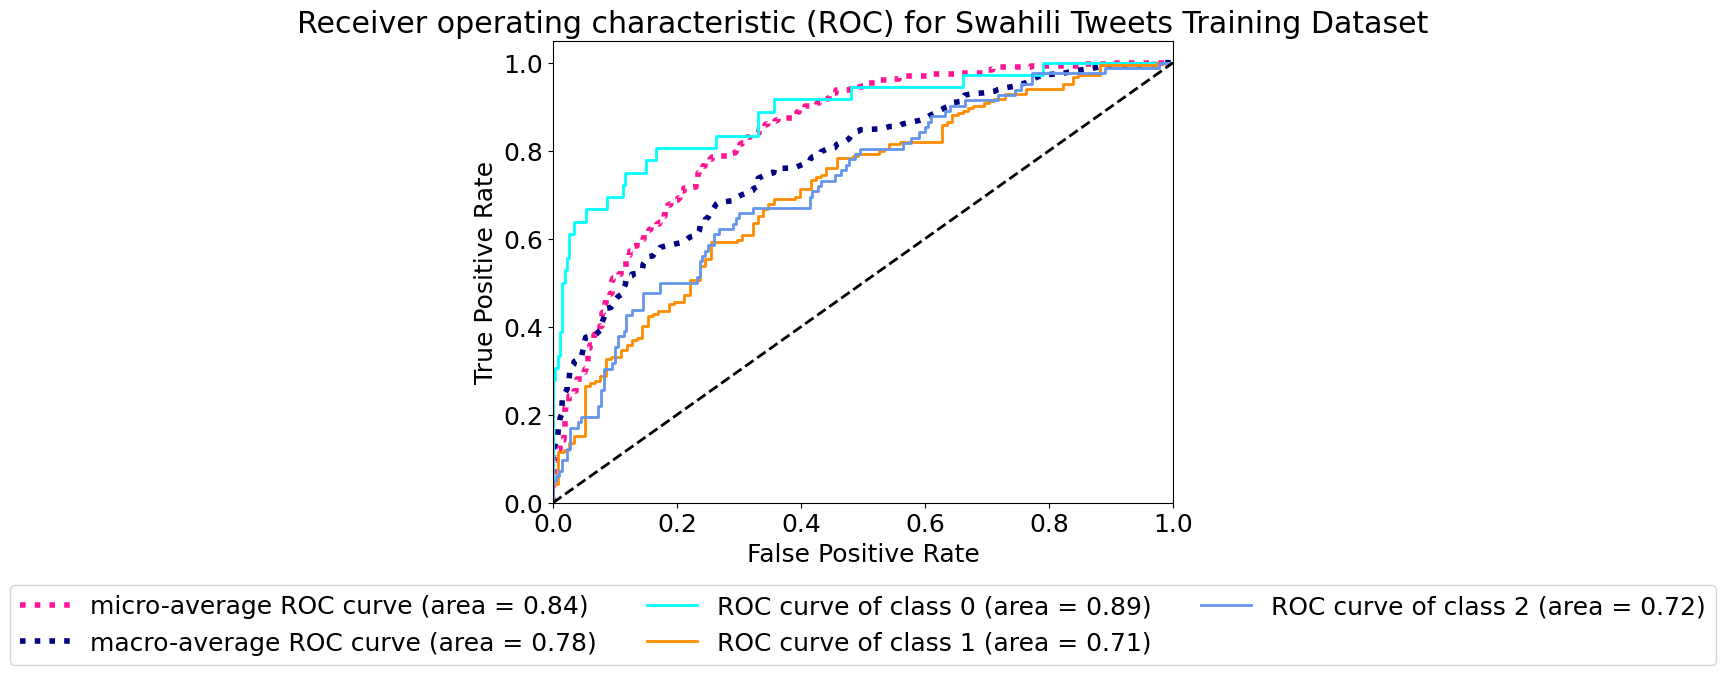

In [ ]:
# PLOT ROC
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import keras

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(binarized_y_true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binarized_y_true_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot all ROC curves
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic (ROC) for Swahili Tweets Training Dataset')
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize='medium')
plt.show()